In [1]:
from google.colab import drive
drive.mount('/content/drive')

import zipfile
zip_path = '/content/drive/MyDrive/solarflare/SDOBenchmark.zip'
extract_path = '/content/sdo_data'

with zipfile.ZipFile(zip_path, 'r') as z:
    z.extractall(extract_path)

print("Done!")


Mounted at /content/drive


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/solarflare/SDOBenchmark.zip'

In [2]:
# shows top-level folders in MyDrive
!ls -la "/content/drive/MyDrive"

# find anything with SDO or SDOBenchmark
!find "/content/drive/MyDrive" -maxdepth 4 -iname "*sdo*" -o -iname "*sdobench*"


total 835988
-rw------- 1 root root       174 Oct  8  2023 '1 Introduction to CIE.gslides'
-rw------- 1 root root   2465509 Aug 18 04:31 'Activity-2 (Class Activity) (Aug 18, 2025 at 10:01 AM).jpg'
-rw------- 1 root root    135263 Sep 13 21:31  AndrewResumeWorkshop__1_.pdf
-rw------- 1 root root     32300 Jul 16 04:28  AntiraggingAffidavitForm.pdf
-rw------- 1 root root       174 Sep 26  2024 'ASSIGNMENT-01 STW.gdoc'
-rw------- 1 root root     55395 Sep 26  2024 'ASSIGNMENT-01 STW.pdf'
-rw------- 1 root root   1902177 Dec  3  2023 'ASSIGNMENT -02.pdf'
drwx------ 2 root root      4096 Dec 10 07:56  auditory_eeg
-rw------- 1 root root 824318816 Dec 26 16:24  auditory_eeg_1_0_0.zip
-rw------- 1 root root    990251 Jun 11  2025  AWS_Academy_Graduate___AWS_Academy_Machine_Learning_Foundations_Badge20250322-27-938qf8.pdf
-rw------- 1 root root       174 Sep 16 04:40 'Blank Quiz (1).gform'
-rw------- 1 root root       174 Sep 16 07:29 'Blank Quiz.gform'
-rw------- 1 root root       174 Sep 16

In [3]:
%%bash
ZIP_PATH="/content/drive/MyDrive/solar_flare_project/SDOBenchmark-data-example.zip"

echo "Checking path: $ZIP_PATH"

if [ -f "$ZIP_PATH" ]; then
  echo "✅ ZIP exists! Size:"
  ls -lh "$ZIP_PATH"
else
  echo "❌ ZIP NOT FOUND at that exact path."
  echo "📂 Listing folder contents:"
  ls -la "/content/drive/MyDrive/solar_flare_project"
fi


Checking path: /content/drive/MyDrive/solar_flare_project/SDOBenchmark-data-example.zip
✅ ZIP exists! Size:
-rw------- 1 root root 266M Nov 28 19:45 /content/drive/MyDrive/solar_flare_project/SDOBenchmark-data-example.zip


In [4]:
%%bash
DEST_DIR="/content/solarflare_data"

mkdir -p "$DEST_DIR"

echo "Unzipping dataset..."
unzip -q "/content/drive/MyDrive/solar_flare_project/SDOBenchmark-data-example.zip" -d "$DEST_DIR"

echo "Unzip complete. Top-level contents:"
ls -la "$DEST_DIR"


Unzipping dataset...
Unzip complete. Top-level contents:
total 12
drwxr-xr-x 3 root root 4096 Jan  6 10:26 .
drwxr-xr-x 1 root root 4096 Jan  6 10:26 ..
drwxr-xr-x 4 root root 4096 Jun 19  2018 SDOBenchmark-data-example


In [5]:
 %%bash
FIRST_TS=$(find /content/solarflare_data/SDOBenchmark-data-example/training -maxdepth 2 -type d -name "201*" | head -n1)
echo "First timestamp folder found:"
echo "$FIRST_TS"
echo
ls -la "$FIRST_TS"


First timestamp folder found:
/content/solarflare_data/SDOBenchmark-data-example/training/11528/2012_07_24_12_00_00_0

total 388
drwxr-xr-x 2 root root  4096 Jun 19  2018 .
drwxr-xr-x 4 root root  4096 Jun 19  2018 ..
-rw-r--r-- 1 root root  8120 Jun 19  2018 2012-07-24T000000__131.jpg
-rw-r--r-- 1 root root  9660 Jun 19  2018 2012-07-24T000000__1700.jpg
-rw-r--r-- 1 root root  6517 Jun 19  2018 2012-07-24T000000__171.jpg
-rw-r--r-- 1 root root  5158 Jun 19  2018 2012-07-24T000000__193.jpg
-rw-r--r-- 1 root root  4859 Jun 19  2018 2012-07-24T000000__211.jpg
-rw-r--r-- 1 root root  5954 Jun 19  2018 2012-07-24T000000__304.jpg
-rw-r--r-- 1 root root  6436 Jun 19  2018 2012-07-24T000000__335.jpg
-rw-r--r-- 1 root root 10470 Jun 19  2018 2012-07-24T000000__94.jpg
-rw-r--r-- 1 root root  5431 Jun 19  2018 2012-07-24T000000__continuum.jpg
-rw-r--r-- 1 root root  8802 Jun 19  2018 2012-07-24T000000__magnetogram.jpg
-rw-r--r-- 1 root root  8302 Jun 19  2018 2012-07-24T070000__131.jpg
-rw-r--r-

IMPORTANT: The filenames follow this pattern:
(WE ARE CONSIDERING 3 CHANNELS FOR FROM THE GIVEN DATASET)
<timestamp>__171.jpg
<timestamp>__193.jpg
<timestamp>__211.jpg


So our loader must find images based on "__171.jpg", not "aia_171".

This is why your earlier loader wouldn’t match anything.

In [6]:
from pathlib import Path

ROOT = Path("/content/solarflare_data/SDOBenchmark-data-example/training")

ar_folder = next(ROOT.iterdir())           # e.g., 11388
ts_folder = next(ar_folder.iterdir())      # e.g., 2012_01_01_19_06_00_0

print("Testing folder:", ts_folder)


Testing folder: /content/solarflare_data/SDOBenchmark-data-example/training/11528/2012_07_24_12_00_00_0


In [7]:
import os
import numpy as np
from PIL import Image

def load_multichannel(ts_folder, channels=("171","193","211"), size=(128,128)):
    files = os.listdir(ts_folder)
    imgs = []

    for ch in channels:
        cand = [f for f in files if f.endswith(f"_{ch}.jpg")]
        if not cand:
            print("Missing channel:", ch)
            return None

        img = Image.open(os.path.join(ts_folder, cand[0])).convert("L").resize(size)
        imgs.append(np.array(img, dtype=np.float32) / 255.0)

    return np.stack(imgs, axis=-1)


In [8]:
from pathlib import Path

ts_folder = Path("/content/solarflare_data/SDOBenchmark-data-example/training")

# list ONE real AR
print(next(ts_folder.iterdir()))

# list ONE real timestamp folder
ar = next(ts_folder.iterdir())
print(next(ar.iterdir()))


/content/solarflare_data/SDOBenchmark-data-example/training/11528
/content/solarflare_data/SDOBenchmark-data-example/training/11528/2012_07_24_12_00_00_0


In [9]:
ts_folder = "/content/solarflare_data/SDOBenchmark-data-example/training/11838/2013_09_11_10_54_00_0"
arr = load_multichannel(ts_folder)
print(arr.shape)


(128, 128, 3)


In [10]:
# show top of dataset dir
%%bash
echo "Root listing:"
ls -la /content/solarflare_data/SDOBenchmark-data-example

echo
echo "Count sample 171 images (should be many):"
find /content/solarflare_data/SDOBenchmark-data-example -type f -iname "*__171.jpg" | wc -l

echo
echo "Show first 20 sample paths:"
find /content/solarflare_data/SDOBenchmark-data-example -type f -iname "*__171.jpg" | sed -n '1,20p'


Root listing:
total 28
drwxr-xr-x   4 root root  4096 Jun 19  2018 .
drwxr-xr-x   3 root root  4096 Jan  6 10:26 ..
-rw-r--r--   1 root root  1182 Jun 19  2018 README.txt
drwxr-xr-x  37 root root  4096 Jun 19  2018 test
drwxr-xr-x 465 root root 12288 Jun 19  2018 training

Count sample 171 images (should be many):
3336

Show first 20 sample paths:
/content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T165501__171.jpg
/content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T132501__171.jpg
/content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T181501__171.jpg
/content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T062501__171.jpg
/content/solarflare_data/SDOBenchmark-data-example/test/12576/2016_08_16_10_01_01_0/2016-08-16T083101__171.jpg
/content/solarflare_data/SDOBenchmark-data-example/test/12576/2016_08_16_10_01_01_0/2016-08-16T

In [11]:
import os
from pathlib import Path
import cv2
ROOT=Path("/content/solarflare_data/SDOBenchmark-data-example")

# accepted image extensions
EXTS=[".jpg",".png",".jpeg"]

grayscale=0
color=0
fake_gray=0
corrupted=0

print("scanning dataset....\n")

for img_path in ROOT.rglob("*"):
  if img_path.suffix.lower() not in EXTS:
    continue

  img=cv2.imread(str(img_path),cv2.IMREAD_UNCHANGED)

  if img is None:
    print(f"[CORRUPTED] {img_path}")
    corrupted+=1
    continue

    # case 1:pure scale(H,W)
    if len(Img.shape)==2:
      grayscale+=1
      continue

    # case 2:color/BGRA(H,W,C)
    if len(img.shape)==3:
      h,w,c=img.shape

      # 3 channel image
      if c==3:
        # check if its visually grayscale:R=G=B everywhere
        b,g,r=cv2.split(img)
        if(b==g).all() and (g==r).all():
          fake_gray+=1

        else:
          color+=1

      elif c==4:
        color+=1

# SUMMARY
print("\n================ SUMMARY ================\n")
print(f"Pure grayscale images     : {grayscale}")
print(f"Fake grayscale (3-channel): {fake_gray}")
print(f"True color images         : {color}")
print(f"Corrupted images          : {corrupted}")
print("\n=========================================\n")






scanning dataset....


================ SUMMARY ================

Pure grayscale images     : 0
Fake grayscale (3-channel): 0
True color images         : 0
Corrupted images          : 0




In [13]:
from pathlib import Path
import cv2
from collections import Counter

# --- set this to your dataset root (Path object) ---
ROOT = Path("/content/solarflare_data/SDOBenchmark-data-example")

# acceptable image extensions (lowercase)
EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

# counters
cnt_gray = 0
cnt_fake_gray = 0
cnt_color = 0
cnt_4ch = 0
cnt_corrupted = 0
total_files = 0

# small lists to show examples
examples = {
    "gray": [],
    "fake_gray": [],
    "color": [],
    "4ch": [],
    "corrupted": []
}

print("Scanning:", ROOT)
print("Exists?", ROOT.exists(), "Is dir?", ROOT.is_dir())
print()

# Use "*.*" so we capture typical files; this will also list CSV/TXT so we filter by suffix.
all_files = list(ROOT.rglob("*.*"))
print("Total files found with a dot in name:", len(all_files))

# If you want to include dotless names (rare), you could do ROOT.rglob("*") as fallback.

for p in all_files:
    sfx = p.suffix.lower()
    if sfx not in EXTS:
        continue
    total_files += 1

    img = cv2.imread(str(p), cv2.IMREAD_UNCHANGED)
    if img is None:
        cnt_corrupted += 1
        if len(examples["corrupted"]) < 5:
            examples["corrupted"].append(str(p))
        continue

    # grayscale saved as single channel -> shape has length 2
    if img.ndim == 2:
        cnt_gray += 1
        if len(examples["gray"]) < 5:
            examples["gray"].append(str(p))
        continue

    # color-like arrays (H, W, C)
    if img.ndim == 3:
        h, w, c = img.shape
        if c == 1:
            # sometimes OpenCV returns (H,W,1) — treat as grayscale
            cnt_gray += 1
            if len(examples["gray"]) < 5:
                examples["gray"].append(str(p))
            continue
        elif c == 3:
            # check if visually grayscale: B == G == R everywhere
            b, g, r = cv2.split(img)
            if (b == g).all() and (g == r).all():
                cnt_fake_gray += 1
                if len(examples["fake_gray"]) < 5:
                    examples["fake_gray"].append(str(p))
            else:
                cnt_color += 1
                if len(examples["color"]) < 5:
                    examples["color"].append(str(p))
            continue
        elif c == 4:
            cnt_4ch += 1
            if len(examples["4ch"]) < 5:
                examples["4ch"].append(str(p))
            continue
        else:
            # unexpected channel count
            cnt_corrupted += 1
            if len(examples["corrupted"]) < 5:
                examples["corrupted"].append(str(p))
            continue

# Summary output
print("\n===== SUMMARY =====")
print("Total files scanned (matching EXTS):", total_files)
print("Pure grayscale (H,W):", cnt_gray)
print("Fake grayscale (3-channel where B==G==R):", cnt_fake_gray)
print("True color (3-channel, B!=G!=R):", cnt_color)
print("4-channel (e.g. BGRA):", cnt_4ch)
print("Unreadable / corrupted (cv2 returned None):", cnt_corrupted)
print("====================\n")

# Print a few example paths for each category
for k, v in examples.items():
    if v:
        print(f"Examples of {k} (up to 5):")
        for p in v:
            print("  ", p)
        print()


Scanning: /content/solarflare_data/SDOBenchmark-data-example
Exists? True Is dir? True

Total files found with a dot in name: 33358

===== SUMMARY =====
Total files scanned (matching EXTS): 33355
Pure grayscale (H,W): 33355
Fake grayscale (3-channel where B==G==R): 0
True color (3-channel, B!=G!=R): 0
4-channel (e.g. BGRA): 0
Unreadable / corrupted (cv2 returned None): 0

Examples of gray (up to 5):
   /content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T181501__193.jpg
   /content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T181501__335.jpg
   /content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T132501__continuum.jpg
   /content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T132501__131.jpg
   /content/solarflare_data/SDOBenchmark-data-example/test/12267/2015_01_23_18_25_01_0/2015-01-23T181501__304.jpg



In [14]:
# Resizing the images
from pathlib import Path
import cv2
from collections import Counter
#
ROOT=Path("/content/solarflare_data/SDOBenchmark-data-example")
# defining the input and output base to store the resized imgs
RESIZED_BASE=Path("/content/solarflare_resized")
RESIZED_BASE.mkdir(parents=True,exist_ok=True)

def map_resized_path(in_path):
  rel=in_path.relative_to(ROOT)
  out_path=RESIZED_BASE/rel
  out_path.parent.mkdir(parents=True,exist_ok=True)
  return out_path

EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}
print("Scanning:", ROOT)
print("Exists?", ROOT.exists(), "Is dir?", ROOT.is_dir())
print()

print("Total files found with a dot in name:", len(all_files))
total_files=0
# iterate through the files
for p in all_files:
  sfx=p.suffix.lower()
  if sfx not in EXTS:
    continue

  img=cv2.imread(str(p),cv2.IMREAD_UNCHANGED)
  if img is None:
    continue
  # resize to 224x224
  resized=cv2.resize(img,(224,224),interpolation=cv2.INTER_LINEAR)
  out_path=map_resized_path(p)
  cv2.imwrite(str(out_path),resized)

  total_files+=1

print("\nDone resizing step (in memory only).")
print("Total valid images processed:", total_files)
print("Saved to:", RESIZED_BASE)


Scanning: /content/solarflare_data/SDOBenchmark-data-example
Exists? True Is dir? True

Total files found with a dot in name: 33358

Done resizing step (in memory only).
Total valid images processed: 33355
Saved to: /content/solarflare_resized


In [15]:
from pathlib import Path
import cv2
import matplotlib.pyplot as plt

ROOT = Path("/content/solarflare_data/SDOBenchmark-data-example")
RESIZED_BASE = Path("/content/solarflare_resized_clahe")
RESIZED_BASE.mkdir(parents=True, exist_ok=True)

def map_resized_path(in_path):
    rel = in_path.relative_to(ROOT)
    out_path = RESIZED_BASE / rel
    out_path.parent.mkdir(parents=True, exist_ok=True)
    return out_path

EXTS = {".jpg", ".jpeg", ".png", ".tif", ".tiff", ".bmp"}

clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
saved_paths = []

all_files = list(ROOT.rglob("*.*"))

for p in all_files:
    if p.suffix.lower() not in EXTS:
        continue

    img = cv2.imread(str(p), cv2.IMREAD_GRAYSCALE)
    if img is None:
        continue

    # 1️⃣ Resize
    resized = cv2.resize(img, (224, 224), interpolation=cv2.INTER_LINEAR)

    # 2️⃣ Apply CLAHE
    cl1 = clahe.apply(resized)

    # 3️⃣ Save
    out_path = map_resized_path(p)
    cv2.imwrite(str(out_path), cl1)

    saved_paths.append(out_path)

print("CLAHE outputs saved:", len(saved_paths))


CLAHE outputs saved: 33355


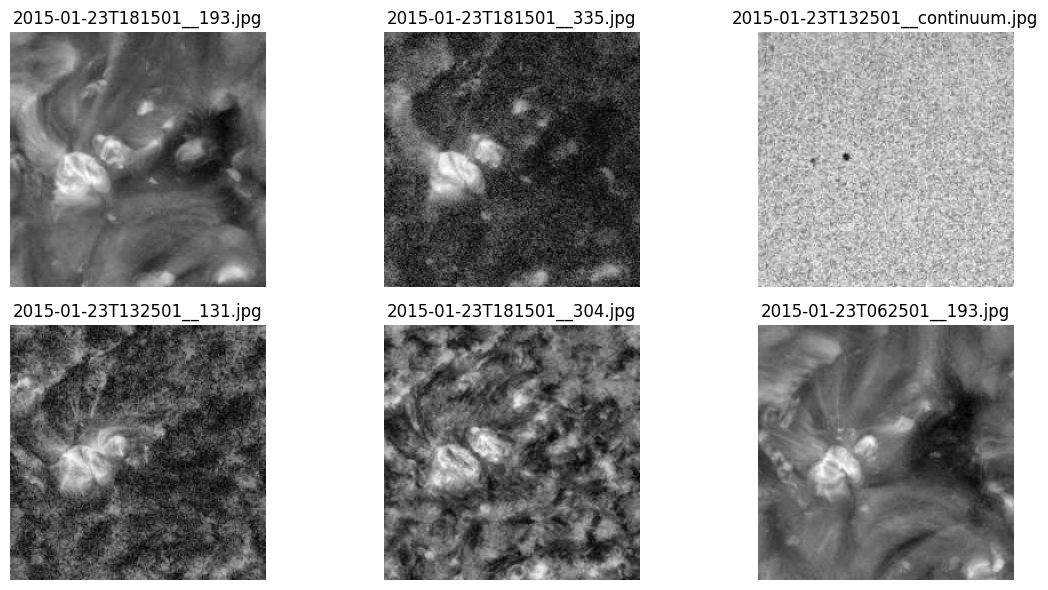

In [17]:
import matplotlib.pyplot as plt
import cv2

# take first 6 saved CLAHE images
sample_paths = saved_paths[:6]

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{path.name}")
    plt.axis("off")

plt.tight_layout()
plt.show()


In [18]:
# checking if all the images have been resized properly
from pathlib import Path
import cv2
import random

RESIZED_BASE=Path("/content/solarflare_resized")
EXTS= {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}
all_resized=list(RESIZED_BASE.rglob("*.*"))

ok=0
bad_shape=0
corrupted=0

BAD_SHAPES=[]

for p in all_resized:
  if p.suffix.lower() not in EXTS:
    continue
  img=cv2.imread(str(p),cv2.IMREAD_GRAYSCALE)

  if img is None:
    corrupted+=1
    continue

  if img.shape!=(224,224):
    bad_shape+=1
    BAD_SHAPES.append((p,img.shape))
  else:
    ok+=1

print("=== RESIZE VERIFICATION ===")
print("Total images scanned:", len(all_resized))
print("Correct shape (224x224):", ok)
print("Incorrect shapes:", bad_shape)
print("Corrupted images:", corrupted)

if bad_shape > 0:
    print("\nSome bad shapes:")
    for item in BAD_SHAPES[:10]:
        print(item)


=== RESIZE VERIFICATION ===
Total images scanned: 33355
Correct shape (224x224): 33355
Incorrect shapes: 0
Corrupted images: 0


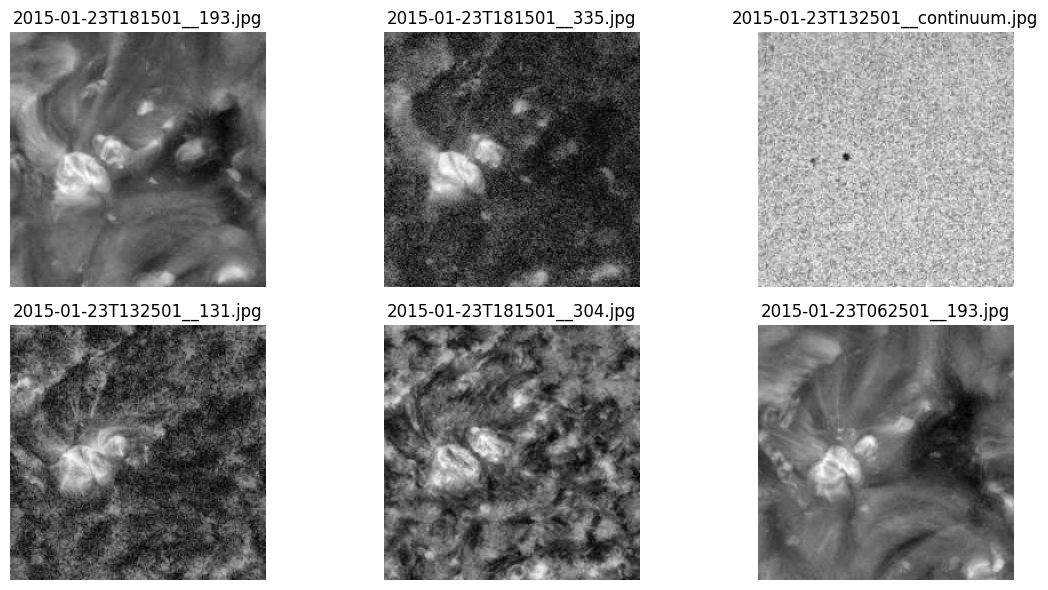

In [19]:
# plotting random resied images

import matplotlib.pyplot as plt
import cv2

# take first 6 saved CLAHE images
sample_paths = saved_paths[:6]

plt.figure(figsize=(12, 6))

for i, path in enumerate(sample_paths):
    img = cv2.imread(str(path), cv2.IMREAD_GRAYSCALE)

    plt.subplot(2, 3, i+1)
    plt.imshow(img, cmap='gray')
    plt.title(f"{path.name}")
    plt.axis("off")

plt.tight_layout()
plt.show()

In [16]:
# Applying z-score(gives more stable CNN behaviour) and min-max normalization(preserves intensirt differences)
# Most solar ML pipelines use Z-score after CLAHE.

from pathlib import Path
import cv2
import numpy as np

NORM_INPUT = Path("/content/solarflare_resized_clahe")
NORM_OUTPUT_MINMAX = Path("/content/solarflare_normalized_minmax")
NORM_OUTPUT_ZSCORE = Path("/content/solarflare_normalized_zscore")

# output paths for both types of normalization

NORM_OUTPUT_MINMAX.mkdir(parents=True, exist_ok=True)
NORM_OUTPUT_ZSCORE.mkdir(parents=True, exist_ok=True)


EXTS = {".jpg", ".jpeg", ".png", ".bmp", ".tif", ".tiff"}

def map_norm_path(in_path, out_base, new_suffix=".npy"):
    rel = in_path.relative_to(NORM_INPUT)
    out_path = out_base / rel
    out_path = out_path.with_suffix(new_suffix)
    out_path.parent.mkdir(parents=True, exist_ok=True)
    return out_path

all_files = list(NORM_INPUT.rglob("*.*"))

count = 0

for p in all_files:
  if p.suffix.lower() not in EXTS:
    continue

  img=cv2.imread(str(p),cv2.IMREAD_GRAYSCALE)
  if img is None:
    continue
  img=img.astype(np.float32)

  # min-max:
  mn,mx=img.min(),img.max()
  if mx-mn>0:
    minmax_norm=(img-mn)/(mx-mn)
  else:
    minmax_norm=np.zeros_like(img)

  # save the min-max normalized

  out_path_min = map_norm_path(p, NORM_OUTPUT_MINMAX)
  np.save(out_path_min, minmax_norm)

  # z-score:
  mean,std=img.mean(),img.std()

  z_norm=(img-mean)/(std+1e-6)

  # Save z-score normalized
  out_path_z = map_norm_path(p, NORM_OUTPUT_ZSCORE)
  np.save(out_path_z, z_norm)

  count += 1

print("Normalization complete for", count, "images.")
print("Min-max saved to:", NORM_OUTPUT_MINMAX)
print("Z-score saved to:", NORM_OUTPUT_ZSCORE)


Normalization complete for 33355 images.
Min-max saved to: /content/solarflare_normalized_minmax
Z-score saved to: /content/solarflare_normalized_zscore


In [17]:
import os
import numpy as np
import pandas as pd
from pathlib import Path
from tqdm.auto import tqdm

# ===== Paths =====
ROOT = Path("/content/solarflare_data/SDOBenchmark-data-example")
PIXELS_BASE = Path("/content/solarflare_normalized_minmax")

META_CSV = ROOT / "training" / "meta_data.csv"
IMG_SIZE = (224, 224)
CHANNELS = ["171", "193", "211"]
PEAK_FLUX_THRESHOLD = 1e-6

# ===== Helper: stack normalized channels =====
def stack_from_folder(folder):
    imgs = []
    folder = Path(folder)

    for ch in CHANNELS:
        # find original image (ONLY for channel identity)
        candidates = (
            list(folder.glob(f"*__{ch}.jpg")) +
            list(folder.glob(f"*_{ch}.jpg")) +
            [f for f in folder.iterdir() if ch in f.name]
        )

        if not candidates:
            return None

        original_path = candidates[0]

        # map original path → normalized .npy
        rel = original_path.relative_to(ROOT)
        norm_path = (PIXELS_BASE / rel).with_suffix(".npy")

        if not norm_path.exists():
            return None

        img = np.load(norm_path)

        # safety check
        if img.shape != IMG_SIZE:
            return None

        imgs.append(img.astype(np.float32))

    return np.stack(imgs, axis=-1)  # (224,224,3)

# ===== Find all reference 171 files =====
files_171 = list(ROOT.rglob("*__171.jpg"))
if len(files_171) == 0:
    raise RuntimeError("No __171 files found in original dataset.")

print("Found __171 files:", len(files_171))

# ===== Stack dataset =====
entries = []

for p in tqdm(files_171, desc="Stacking channels"):
    folder = p.parent
    stacked = stack_from_folder(folder)
    if stacked is None:
        continue

    # find AR number
    ar = "UNK"
    for anc in folder.parents:
        if anc.name.isdigit():
            ar = anc.name
            break

    sample_id = f"{ar}_{folder.name}"
    entries.append((sample_id, stacked, folder))

print("Total stacked samples:", len(entries))

# ===== Train/Test split =====
train_entries, test_entries = [], []

for sid, arr, folder in entries:
    if "/training/" in str(folder):
        train_entries.append((sid, arr))
    elif "/test/" in str(folder):
        test_entries.append((sid, arr))

print("Train samples:", len(train_entries))
print("Test samples :", len(test_entries))

# ===== Load labels =====
meta_df = pd.read_csv(META_CSV)
meta_df["id"] = meta_df["id"].astype(str).str.strip()
meta_map = meta_df.set_index("id")["peak_flux"].to_dict()

# ===== Build arrays =====
X_train = np.stack([e[1] for e in train_entries])
X_test  = np.stack([e[1] for e in test_entries])

train_ids = [e[0] for e in train_entries]

y_reg = np.array(
    [float(meta_map.get(cid, np.nan)) for cid in train_ids],
    dtype=np.float32
)

y_bin = np.array(
    [
        1 if (not np.isnan(x) and x >= PEAK_FLUX_THRESHOLD)
        else (0 if not np.isnan(x) else -1)
        for x in y_reg
    ],
    dtype=np.int32
)

# ===== Save =====
np.save("/content/X_train.npy", X_train)
np.save("/content/X_test.npy", X_test)
np.save("/content/y_reg_train.npy", y_reg)
np.save("/content/y_bin_train.npy", y_bin)

print("Saved arrays:")
print("X_train:", X_train.shape)
print("X_test :", X_test.shape)
print("y_reg  :", y_reg.shape)
print("y_bin  :", y_bin.shape)


Found __171 files: 3336


Stacking channels:   0%|          | 0/3336 [00:00<?, ?it/s]

Total stacked samples: 3336
Train samples: 3156
Test samples : 180
Saved arrays:
X_train: (3156, 224, 224, 3)
X_test : (180, 224, 224, 3)
y_reg  : (3156,)
y_bin  : (3156,)


In [18]:
from pathlib import Path

ROOT = Path("/content/solarflare_data/SDOBenchmark-data-example")

samples = []

for p in ROOT.rglob("*.jpg"):
    samples.append(p.name)
    if len(samples) >= 20:
        break

samples


['2015-01-23T181501__193.jpg',
 '2015-01-23T181501__335.jpg',
 '2015-01-23T132501__continuum.jpg',
 '2015-01-23T132501__131.jpg',
 '2015-01-23T181501__304.jpg',
 '2015-01-23T062501__193.jpg',
 '2015-01-23T132501__94.jpg',
 '2015-01-23T165501__171.jpg',
 '2015-01-23T165501__1700.jpg',
 '2015-01-23T062501__continuum.jpg',
 '2015-01-23T062501__131.jpg',
 '2015-01-23T132501__193.jpg',
 '2015-01-23T062501__304.jpg',
 '2015-01-23T062501__magnetogram.jpg',
 '2015-01-23T132501__magnetogram.jpg',
 '2015-01-23T165501__94.jpg',
 '2015-01-23T181501__continuum.jpg',
 '2015-01-23T132501__211.jpg',
 '2015-01-23T181501__94.jpg',
 '2015-01-23T132501__304.jpg']

In [19]:
# applying transfer learning for binary classficcaion to see whehter the falames in the dataset is apt for GMD or not
import torchvision
weights=torchvision.models.EfficientNet_B0_Weights.DEFAULT
weights


EfficientNet_B0_Weights.IMAGENET1K_V1

In [20]:
# Setup device agnostic code
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
device


'cpu'

In [21]:
# setting up a pretrained model
# The pretrained model we're going to be using is torchvision.models.efficientnet_b0().
# (we have set the weights before)

model=torchvision.models.efficientnet_b0(weights=weights).to(device)

In [22]:

# 3.4 Freezing the base model and changing the output layer to suit our needs

# FREEZE ALL THE BASE LAYERS IN THE 'FEATURES' SECTION OF THE MODEL
for param in model.features.parameters():
  param.requires_grad=False

In [23]:
# set the manual seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# recreate the classifier layer and seed it to the target device
model.classifier=torch.nn.Sequential(
    torch.nn.Dropout(p=0.2,inplace=True),
    torch.nn.Linear(in_features=1280,
                    out_features=1,
                    bias=True)
).to(device)

In [54]:
  !pip install torchinfo

In [24]:
# training the model
import torch.nn as nn
# define the loss and optimizer
loss_fn = nn.BCEWithLogitsLoss() #binary loss
optimizer = torch.optim.Adam(
    model.classifier.parameters(),
    lr=1e-3
)


In [25]:
# BEFORE TRAINING WE NEED TO TRANSFORM THE DATASET INTO TENSORS TO PERFORM TRAINING ON IT

import torch
from torch.utils.data import DataLoader
from torchvision import datasets,transforms

Why YOU should not use transforms.ToTensor()


WE CANT APPLY 'transforms.ToTensor()' SINCE IT IS USED FOR PIL IMAGES/NUMPY ARRAY(H,W,C) OR Your images are in "regular image format" OR
 You still want/need to convert and normalize inside PyTorch

Your images are already preprocessed:

Already CLAHE’d

Already resized

Already normalized (Z-score or minmax)

Already saved as .npy arrays

Already INTENTIONALLY shaped as (224,224) (single channel)

Pixel range is not 0–255 anymore — you changed it in preprocessing

So if you gave THESE to ToTensor():

❌ Problem 1 → It will divide your values by 255 again

That breaks your normalization.

❌ Problem 2 → It expects H×W×C but your inputs are H×W

It will think your image has no channel, give wrong output shape, or error.

❌ Problem 3 → You aren’t using PIL images anymore

Your dataset consists of NumPy arrays, not raw .jpg files.

In [26]:
# trasnforming the data with torchvision.
import torch

def np_to_tensor(x):
  # x is (224,224)-> add channel dimension -> (3,224,224)
  x=torch.tensor(x,dtype=torch.float32)
  x=x.permute(2,0,1) #reordering the channels(not our dataset-related one)
  return x

# to make our (224,224) channel transform into the shape accepted by pytorch i.e. -> (1,224,224)

🔥 THERE ARE TWO DIFFERENT “3 CHANNELS” IN THIS PROJECT
✅ (A) The REAL 3-Channel Input (171, 193, 211 Å)

These come from stacking the solar images:

[171 Å] → channel 0  
[193 Å] → channel 1  
[211 Å] → channel 2


So after stacking, your input shape per sample is:

(224, 224, 3)   # NumPy  
(3, 224, 224)   # PyTorch (after transform)


👉 THAT 3 IS PHYSICALLY MEANINGFUL.
It represents three different wavelengths = three inputs to the EfficientNet.

This WILL NOT CHANGE.

❌ (B) The “add channel dimension” trick (1,224,224)

THAT ONE is only for single-channel images, like MNIST or grayscale.

But your solar images are NOT single-channel anymore.
They are 3-channel images because of stacking.

So this:

x = torch.tensor(x).unsqueeze(0)


❌ is needed ONLY IF your image is (224,224).
❌ NOT NEEDED once images are (224,224,3).

In [27]:
class SolarNPYDatasetV2(torch.utils.data.Dataset):
    def __init__(self, X_path, y_path):
        self.X = np.load(X_path)   # shape: (N,224,224,3)
        self.y = np.load(y_path)   # shape: (N,)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        x = self.X[idx]                       # (224,224,3)
        x = torch.from_numpy(x).permute(2,0,1).float()  # (3,224,224)
        y = self.y[idx]
        if y == -1:
          y = 0

        y = torch.tensor(y).float()
        return x, y


In [32]:
import numpy as np
from sklearn.model_selection import train_test_split

# Load prepared training data
X = np.load("/content/X_train.npy")
y = np.load("/content/y_bin_train.npy")

# Remove invalid labels
mask = y != -1
X = X[mask]
y = y[mask]

# Train / validation split
X_train_final, X_val, y_train_final, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [33]:
np.save("/content/X_train_final.npy", X_train_final)
np.save("/content/y_train_final.npy", y_train_final)
np.save("/content/X_val.npy", X_val)
np.save("/content/y_val.npy", y_val)


In [34]:
train_ds_v2 = SolarNPYDatasetV2(
    "/content/X_train.npy",
    "/content/y_bin_train.npy"
)

val_ds = SolarNPYDatasetV2(
    "/content/X_val.npy",
    "/content/y_val.npy"
)



In [35]:
x0, y0 = train_ds_v2[0]
print(x0.shape, y0)


torch.Size([3, 224, 224]) tensor(0.)


1️⃣ torch.Size([3, 224, 224])

Perfect. This means:

3 channels → your stacked wavelengths [171, 193, 211]

224 × 224 → matches EfficientNet / ImageNet expectations

Channel-first → PyTorch format ✅

So your data tensor is 100% correct for CNNs.

2️⃣ tensor(-1.)

This is the label.

-1 = unknown / missing label

This came from your earlier logic:

y_bin = -1  # when peak_flux is NaN


So nothing is broken here either.

🚨 Important (but expected) thing to handle next

You cannot train with -1 labels.

So before training, you must filter them out.

Two clean options (pick one)
✅ Option A (recommended): Filter at dataset creation

Only keep samples where y != -1.

⚠️ Option B: Ignore in loss

Messy, not worth it for Phase 1.

In [38]:
train_dl_v2 = torch.utils.data.DataLoader(
    train_ds_v2,
    batch_size=32,
    shuffle=True,
    num_workers=0
)

val_dl = torch.utils.data.DataLoader(
    val_ds,
    batch_size=32,
    shuffle=False,   # IMPORTANT: never shuffle validation
    num_workers=0
)

xb, yb = next(iter(train_dl_v2))
print(xb.shape, yb.shape)


torch.Size([32, 3, 224, 224]) torch.Size([32])


In [39]:
# check a batch
x_batch, y_batch = next(iter(val_dl))
print(x_batch.shape)  # should be [B, 3, 224, 224]
print(y_batch.unique())


torch.Size([32, 3, 224, 224])
tensor([0., 1.])


class TinyVGG(nn.Module):
    def __init__(self, input_channels=3, hidden_units=32):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(hidden_units * 56 * 56, 1)  # 224 → 112 → 56
        )

    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)


What you are doing (and why it’s different)

Your task is not object recognition.

You are working with:

Scientific images (EUV intensity maps)

Smooth spatial patterns

Global morphology (loops, bright regions, structure)

Regression / binary classification (not 10–100 classes)

So:

You don’t need deep semantic features

You do need stable spatial features

Overly deep models = overfitting + unstable training

👉 That’s why we intentionally simplified the model.

In [40]:
import torch
import torch.nn as nn

class TinyVGG(nn.Module):
    def __init__(self, input_channels=3, hidden_units=32, num_classes=1):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(input_channels, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),

            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        # Assuming input image size = 224×224
        # After 2 poolings → 224 → 112 → 56
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # nn.Linear(hidden_units * 56 * 56, num_classes)
            nn.LazyLinear(out_features=num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x


In [41]:
# model instantiation:
model = TinyVGG(
    input_channels=3,   # EEG channels stacked like image
    hidden_units=32,
    num_classes=1
).to(device)


In [41]:
# Try a forward pass on a single image (to test the model)
img_batch, label_batch = next(iter(train_dl_v2))
img_single = img_batch[0].unsqueeze(0)  # shape: [1, 3, 224, 224]
label_single = label_batch[0]


In [42]:
# Forward pass DONT RUN
model.eval()
with torch.inference_mode():
    logits = model(img_single.to(device))

# Convert logits → probability
prob = torch.sigmoid(logits)

# Convert probability → predicted label
pred_label = (prob > 0.5).int()

print(f"Logits: {logits}")
print(f"Prediction probability: {prob}")
print(f"Predicted label: {pred_label}")
print(f"Actual label: {label_single}")
print("Label after fix:", (label_single + 1) / 2)


Logits: tensor([[0.0155]])
Prediction probability: tensor([[0.5039]])
Predicted label: tensor([[1]], dtype=torch.int32)
Actual label: 0.0
Label after fix: tensor(0.5000)


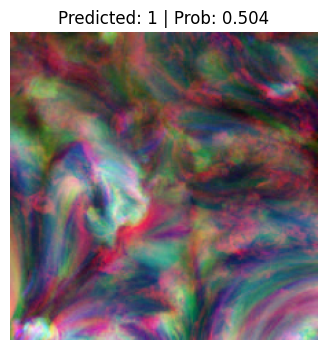

In [43]:
# checking with plotting the image parallely for verifying the prediction:
import matplotlib.pyplot as plt

# Remove batch dimension
img = img_single.squeeze(0)          # [3, 224, 224]

# Move channels last for plotting
img = img.permute(1, 2, 0)

# Convert to numpy
img = img.cpu().numpy()

# Plot
plt.figure(figsize=(4, 4))
plt.imshow(img)
plt.axis("off")

plt.title(
    f"Predicted: {int(pred_label.item())} | "
    f"Prob: {prob.item():.3f}"
)

plt.show()


In [42]:
# training the model
criterion=nn.BCEWithLogitsLoss()
optimizer=torch.optim.Adam(model.parameters(),lr=1e-4)

In [43]:
def train_step(model,
               dataloader,
               loss_fn,
               optimizer,
               device):

    model.train()
    train_loss = 0.0
    train_acc  = 0.0

    for X, y in dataloader:
        X = X.to(device)
        y = y.to(device)

        # Forward pass (logits)
        logits = model(X).squeeze(1)   # [B, 1] → [B]

        # Loss
        loss = loss_fn(logits, y)
        train_loss += loss.item()

        # Backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accuracy (sigmoid + threshold)
        probs = torch.sigmoid(logits)
        preds = (probs >= 0.5).float()
        acc = (preds == y).float().mean()
        train_acc += acc.item()

    train_loss /= len(dataloader)
    train_acc  /= len(dataloader)

    return train_loss, train_acc


In [44]:
# test and validation step
def test_step(model,
              dataloader,
              loss_fn,
              device):

    model.eval()
    test_loss = 0.0
    test_acc  = 0.0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            logits = model(X).squeeze(1)
            loss = loss_fn(logits, y)
            test_loss += loss.item()

            probs = torch.sigmoid(logits)
            preds = (probs >= 0.5).float()
            acc = (preds == y).float().mean()
            test_acc += acc.item()

    test_loss /= len(dataloader)
    test_acc  /= len(dataloader)

    return test_loss, test_acc


In [45]:
epochs = 10

for epoch in range(epochs):
    train_loss, train_acc = train_step(
        model,
        train_dl_v2,
        loss_fn,
        optimizer,
        device
    )

    val_loss, val_acc = test_step(
        model,
        val_dl,   # ✅ validation loader
        loss_fn,
        device
    )

    print(f"Epoch {epoch+1}/{epochs}")
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")
    print(f"Val   Loss: {val_loss:.4f} | Val   Acc: {val_acc:.4f}")
    print("-" * 40)


Epoch 1/10
Train Loss: 0.5270 | Train Acc: 0.7804
Val   Loss: 0.7455 | Val   Acc: 0.5894
----------------------------------------
Epoch 2/10
Train Loss: 0.4860 | Train Acc: 0.7866
Val   Loss: 0.5975 | Val   Acc: 0.6007
----------------------------------------
Epoch 3/10
Train Loss: 0.4203 | Train Acc: 0.8096
Val   Loss: 0.5210 | Val   Acc: 0.6746
----------------------------------------
Epoch 4/10
Train Loss: 0.3466 | Train Acc: 0.8532
Val   Loss: 0.3708 | Val   Acc: 0.8388
----------------------------------------
Epoch 5/10
Train Loss: 0.2834 | Train Acc: 0.8920
Val   Loss: 0.2768 | Val   Acc: 0.9434
----------------------------------------
Epoch 6/10
Train Loss: 0.2245 | Train Acc: 0.9249
Val   Loss: 0.2473 | Val   Acc: 0.9122
----------------------------------------
Epoch 7/10
Train Loss: 0.1748 | Train Acc: 0.9463
Val   Loss: 0.1941 | Val   Acc: 0.9406
----------------------------------------
Epoch 8/10
Train Loss: 0.1303 | Train Acc: 0.9720
Val   Loss: 0.1577 | Val   Acc: 0.9520
-